# Beautiful soup 4 test

In [ ]:
import pip
#pip.main(['install','pandas_datareader'])

In [2]:
from bs4 import BeautifulSoup
import urllib.request
import re
import pandas as pd
from pandas_datareader import data, wb, Options
import matplotlib.pyplot as plt
import datetime
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc
from matplotlib.dates import date2num, DateFormatter
from datetime import datetime

In [150]:
def get_table_data_list(url='http://www.moneycontrol.com/stocks/marketstats/indexcomp.php?optex=NSE&opttopic=indexcomp&index=9'):
  '''
  A function for fetching NSE stock information
  Input: Url of the index page
  Outout: Header and Data list
  '''
  with urllib.request.urlopen(url) as response:
    html = BeautifulSoup(response.read(),'html.parser')
    header=[]
    data=[]
    for row in table.findAll('tr'): 
        # find header row
        if len(header) < 1:
            for col in row.findAll('th'):
                col_b=col.find('b')
                col_br=col.find('br')
                if col_b:
                    header.append(col_b.string)
                elif(col_br):
                    header.append('{0} {1}'.format(col_br.previous_sibling.string,col_br.string) 
                                if col_br.string else col_br.previous_sibling )
                else:
                    header.append(col.string)
                
        row_list=[]    
        for col in row.findAll('td'):
          col_b=col.find('b')
          if col_b:
            row_list.append(col_b.string)
            href=col.find(href=re.compile('stockpricequote'))
            if href:
              row_list.append(href.get('href'))
          else:
            row_list.append(col.string)
        if len(row_list) > 1:    
           data.append(row_list)
    header.insert(1,'Link')
  return header, data

In [151]:
header, data = get_table_data_list()

In [152]:
df=pd.DataFrame(data, columns=header)

In [153]:
def get_stock_info(url_suffix,url_prefix='http://www.moneycontrol.com'):
    '''
    A function for fetching stock information 
    Input: The url suffx for specific stock
    Output: A dict containing current_price, 
    days_low/high,52wk_low/high and NSE symbol
    '''
    url=url_prefix+url_suffix
    data={}
    with urllib.request.urlopen(url_prefix+url_suffix) as response:
        html = BeautifulSoup(response.read(),'html.parser')
        data['current_price']=html.find('div',attrs={'id':'Nse_Prc_tick_div'}).strong.string
        data['days_low']=html.find('span', attrs={'id':'n_low_sh'}).string
        data['days_high']=html.find('span', attrs={'id':'n_high_sh'}).string
        data['52wk_low']=html.find('span', attrs={'id':'n_52low'}).string
        data['52wk_high']=html.find('span', attrs={'id':'n_52high'}).string
        regexp=re.compile('NSE: \w+')
        data['symbol']=re.sub('NSE: ', '', re.search(regexp, html.
                                 find('div',attrs={'class':'PB10'}).
                                 find('div',attrs={'class':'FL gry10'}).
                                 get_text()).group(0))
    return data    

In [154]:
def populate_data_row(data_frame_row):
    '''
    A function for adding additional stock information to the input data frame
    '''
    data=get_stock_info(url_suffix=data_frame_row.Link)
    for key,value in data.items():
        data_frame_row[key]=value
    return data_frame_row

In [155]:
df=df.apply(populate_data_row, axis=1)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [156]:
df.head(3)

,Company Name,Link,Industry,Last Price,Change,%Chg,Mkt Cap,52wk_low,52wk_high,days_low,symbol,current_price,days_high
0,ACC,/india/stockpricequote/cementmajor/acc/ACC06,Cement - Major,"1,486.00",0.50,0.03,"27,905.19",1174.00,1736.40,1480.10,ACC,1484.40,1496.95
1,Adani Ports,/india/stockpricequote/infrastructuregeneral/a...,Infrastructure - General,310.90,6.10,2.00,"64,385.89",169.15,317.00,305.10,ADANIPORTS,311.40,313.70
2,Ambuja Cements,/india/stockpricequote/cementmajor/ambujacemen...,Cement - Major,238.70,0.30,0.13,"47,397.35",185.00,281.70,238.00,AMBUJACEM,238.65,241.30


In [63]:
df=df.set_index('Company Name')

In [76]:
df.Change=df.Change.astype(float)

In [77]:
df.sort_values(by='Change', inplace=True)

In [146]:
def get_moving_average(stock, date, date_window=None):
    '''
    Calculate moving average of a given stock
    Input: Stock symbol and start date
    Output: Dataframe containing MA15, MA50 and EMA15 values and data array
    '''
    # fetch data from yahoo server
    yahoo_data=data.DataReader(stock, 'yahoo',date)
    
    # set date format
    date_format=DateFormatter('%b %y')
    
    # set values for moving average calculation    
    d15=yahoo_data['Adj Close'].rolling(window=15)
    d50=yahoo_data['Adj Close'].rolling(window=50)
    
    # add MA15 and MA50 values to the dataframe    
    yahoo_data=pd.concat([yahoo_data, pd.Series(d15.mean(), name='MA15'),
              pd.Series(d50.mean(),name='MA50')], axis=1).dropna()
    yahoo_data.reset_index(inplace=True)

    # add empty EMA15 value    
    yahoo_data['EMA15']='' 
    
    # add first EMA15 value
    yahoo_data=yahoo_data.set_value(0,'EMA15',yahoo_data.at[0,'MA15']) 
    
    
    # calculate EMA15 values    
    sf=2/(15+1)
    for index, val in enumerate(yahoo_data['EMA15']):
        if val == '':
            ema_val=(yahoo_data.at[index, 'Adj Close'] - yahoo_data.at[index-1, 'EMA15']) * sf + yahoo_data.at[index,'Adj Close']
            yahoo_data=yahoo_data.set_value(index, 'EMA15', ema_val)
    
    # set index for data frame
    yahoo_data=yahoo_data.set_index('Date')        
    yahoo_data['Dates']=date2num(yahoo_data.index.to_pydatetime())
    
    # reset date window
    if date_window:
        yahoo_data=yahoo_data[-date_window:-1]
    
    # generate data_array for matplotlib candlelstick plot
    data_array=[tuple(x) 
            for x in yahoo_data[['Dates','Open','High','Low','Adj Close']].
            to_records(index=False)]
    
    return yahoo_data, data_array

In [147]:
(g2, data_arr)=get_moving_average(stock='ADANIPORTS.NS', date='2016-01-01', date_window=50)

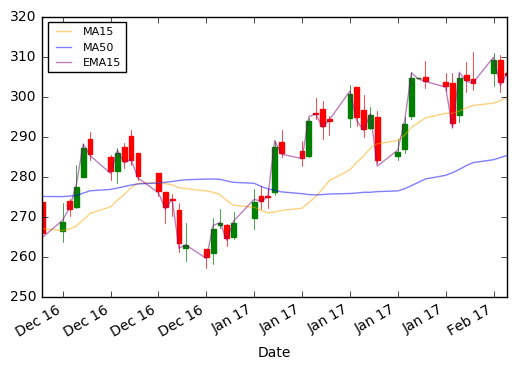

In [148]:
fig,ax=plt.subplots()
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)
mlp=candlestick_ohlc(ax, data_arr, width=0.7, colorup='g', colordown='r' )
g2.MA15.plot(style='-', alpha=0.5, color='orange', label='MA15')
g2.MA50.plot(style='-', alpha=0.5, color='blue', label='MA50')
g2.EMA15.plot(style='-', alpha=0.5, color='purple', label='EMA15')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='best', fontsize=8)
plt.show()